In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import spotipy.client as client

import json
import time

import requests

## Import billboard data

In [11]:
songs_df=pd.read_csv('my_data/songs_billboard.csv')
artists_df=pd.read_csv('my_data/artistes_billboard.csv')
billboard = pd.read_csv('my_data/my_billboard.csv')

## Import spotify features

In [12]:
spotifyFeatures = pd.read_csv("data/features_billboard.csv")

spotifyFeatures=spotifyFeatures[['SongID','spotify_genre','spotify_track_id',
                                 'spotify_track_explicit','spotify_track_duration_ms',
                                'danceability', 'energy', 'loudness', 'speechiness',
                                 'acousticness', 'instrumentalness','valence', 'tempo']]

print(len(spotifyFeatures))

28482


## Change type str to float on features columns

In [13]:
def changeStrFloatToFloat_df(df,column):
    df[column]=df[column].apply(lambda x:str(x))
    df[column]=df[column].apply(lambda x:x.replace(",", "."))
    df[column]=df[column].astype(float)
    
    return df

In [14]:
columns=['danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness','valence', 'tempo']
for col in columns:
    spotifyFeatures=changeStrFloatToFloat_df(spotifyFeatures,col)

## DUPLICATS

In [15]:
print(len(spotifyFeatures))

spotifyFeatures = spotifyFeatures.drop_duplicates() # Presence de 105 duplicats

print(len(spotifyFeatures))

28482
28377


## Merge billboard and spotify data

In [16]:
songs_features_df = pd.merge(songs_df,spotifyFeatures,how='left')

In [17]:
print("len :",len(songs_features_df))
songs_features_df.isnull().sum()

len : 28475


SongID                          0
year                            0
comboWeek                       0
comboInstance                   0
maxPose                         0
top1                            0
top5                            0
top10                           0
spotify_genre                1325
spotify_track_id             4839
spotify_track_explicit       4839
spotify_track_duration_ms    4839
danceability                 4902
energy                       4902
loudness                     4902
speechiness                  4902
acousticness                 4902
instrumentalness             4902
valence                      4902
tempo                        4902
dtype: int64

## Repartion des track ID spotify manquant par année

In [18]:
idMissing = songs_features_df['spotify_track_id'].isnull()
idMissing=idMissing[idMissing == True].index

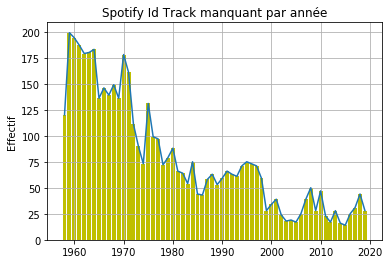

In [19]:
xx=songs_features_df.loc[idMissing]

xx=xx['year'].value_counts().sort_index()

plt.plot(xx.index,xx.values)
plt.bar(xx.index,xx.values,color='y')
plt.grid()
plt.title('Spotify Id Track manquant par année')
plt.ylabel('Effectif')
plt.show()

### RECAP DATAFRAME

In [21]:
songs_features_df.tail()

,SongID,year,comboWeek,comboInstance,maxPose,top1,top5,top10,spotify_genre,spotify_track_id,spotify_track_explicit,spotify_track_duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
28470,What'd You Come Here For?Trina & Tamara,1999,12,1,56,0,0,0,"['deep pop r&b', 'hip pop', 'miami hip hop', '...",1Mg13VMaQj4fhPtQT41vUZ,False,246000.0,0.817,0.625,-3.643,0.0719,0.0508,0.001230,0.759,102.907
28471,What's A Guy Gotta DoJoe Nichols,2005,15,2,64,0,0,0,"['arkansas country', 'contemporary country', '...",3AiNYdRmhXcv7KCFHZOddA,False,141946.0,0.637,0.963,-3.808,0.0770,0.6620,0.000031,0.920,170.224
28472,What's A Matter Baby (Is It Hurting You)Timi Yuro,1962,11,1,12,0,0,0,"['adult standards', 'brill building pop']",5w0dh39SYz1ei2tCs7X7Fo,False,165560.0,0.685,0.760,-9.354,0.0430,0.4300,0.000000,0.895,113.569
28473,Everybody Dies In Their NightmaresXXXTENTACION,2018,7,2,42,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28474,Into The Great Wide OpenTom Petty And The Hear...,1991,5,1,92,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
### SPOTIFY

In [33]:
cid = 'ed490024ea5f4072810146d4d3dff356'
secret = 'b74fa8fd014f4932bb15e79572a104fe'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)

sp = client.Spotify(client_credentials_manager=client_credentials_manager)
sp.trace = False

In [34]:
def getAudioFeatureSpotify(sp,tids):
    return sp.audio_features(tids)[0]

def keepGoodFeatures(features):
    newFeatures={
        'danceability': features['danceability'],
        'energy': features['energy'],
        'key': features['key'],
        'loudness': features['loudness'],
        'mode': features['mode'],
        'speechiness': features['speechiness'],
        'acousticness': features['acousticness'],
        'instrumentalness': features['instrumentalness'],
        'liveness': features['liveness'],
        'valence': features['valence'],
        'tempo': features['tempo'],
        'duration_ms': features['duration_ms'],
                }
    return newFeatures

def addColumnToDF(df,features):
    for i in features.items():
        df[i[0]]=i[1]
    return df

def xxx(ColumnID,sp,columns):
    myDF=pd.DataFrame(columns=columns)
    for i in ColumnID:
        features=keepGoodFeatures(getAudioFeatureSpotify(sp,i))
        features['ID']=i
        myDF=myDF.append(features, ignore_index=True)
        
        #Add sleep to avoid rate limit
        time.sleep(1.0)
        
        #df = addColumnToDF(df,features)
    return myDF

In [63]:
for i in sp.search('Poor Little Fool Ricky Nelson')['tracks']:
    print(sp.search('Poor Little Fool Ricky Nelson')['tracks'][i])
    print('[[[   '+i+'   ]]]')
    print('#'*100)
    
    for j in sp.search('Poor Little Fool Ricky Nelson')['tracks']['items']:
        print('\n')
        print(j)
        print('\n')
        print('#'*100)
        print('\n')

https://api.spotify.com/v1/search?query=Poor+Little+Fool+Ricky+Nelson&type=track&offset=0&limit=10
[[[   href   ]]]
####################################################################################################


{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/73sSFVlM6pkweLXE8qw1OS'}, 'href': 'https://api.spotify.com/v1/artists/73sSFVlM6pkweLXE8qw1OS', 'id': '73sSFVlM6pkweLXE8qw1OS', 'name': 'Ricky Nelson', 'type': 'artist', 'uri': 'spotify:artist:73sSFVlM6pkweLXE8qw1OS'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH',

10
[[[   limit   ]]]
####################################################################################################


{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/73sSFVlM6pkweLXE8qw1OS'}, 'href': 'https://api.spotify.com/v1/artists/73sSFVlM6pkweLXE8qw1OS', 'id': '73sSFVlM6pkweLXE8qw1OS', 'name': 'Ricky Nelson', 'type': 'artist', 'uri': 'spotify:artist:73sSFVlM6pkweLXE8qw1OS'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.

0
[[[   offset   ]]]
####################################################################################################


{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/73sSFVlM6pkweLXE8qw1OS'}, 'href': 'https://api.spotify.com/v1/artists/73sSFVlM6pkweLXE8qw1OS', 'id': '73sSFVlM6pkweLXE8qw1OS', 'name': 'Ricky Nelson', 'type': 'artist', 'uri': 'spotify:artist:73sSFVlM6pkweLXE8qw1OS'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.



{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/73sSFVlM6pkweLXE8qw1OS'}, 'href': 'https://api.spotify.com/v1/artists/73sSFVlM6pkweLXE8qw1OS', 'id': '73sSFVlM6pkweLXE8qw1OS', 'name': 'Ricky Nelson', 'type': 'artist', 'uri': 'spotify:artist:73sSFVlM6pkweLXE8qw1OS'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/08TlIPCh7esOAnqBvlmkEt'}, 'href': 'https://api.spotify.com/v1/albums/08TlIPCh7esOAnqBvlmkEt', 'id': '08TlIPCh7es

In [103]:
def exploreDict(dic,level=-1):
    
    if type(dic) == type({}): 
        for i in dic.keys():
            level+=1
            
            print(level,'-'*level,i)
            
            if type(dic[i]) == type({}) or type(dic[i]) == type([]) :

                exploreDict(dic[i],level=level)
            else :
                level+=1
                print(level,'-'*level,dic[i])
                
    elif type(dic) == type([]):
        if len(dic) > 20 :
            print(level,'-'*level,dic)
        else :
            for i in range(len(dic)):
                if type(dic[i]) == type({}) or type(dic[i]) == type([]) :

                    exploreDict(dic[i],level=level)
                else :
                    print(level,'-'*level,dic[i])

In [113]:
exploreDict(sp.search('Poor Little Fool Ricky Nelson',limit=2,type='track'))

0  tracks
1 - href
2 -- https://api.spotify.com/v1/search?query=Poor+Little+Fool+Ricky+Nelson&type=track&offset=0&limit=2
3 --- items
4 ---- album
5 ----- album_type
6 ------ album
7 ------- artists
8 -------- external_urls
9 --------- spotify
10 ---------- https://open.spotify.com/artist/73sSFVlM6pkweLXE8qw1OS
9 --------- href
10 ---------- https://api.spotify.com/v1/artists/73sSFVlM6pkweLXE8qw1OS
11 ----------- id
12 ------------ 73sSFVlM6pkweLXE8qw1OS
13 ------------- name
14 -------------- Ricky Nelson
15 --------------- type
16 ---------------- artist
17 ----------------- uri
18 ------------------ spotify:artist:73sSFVlM6pkweLXE8qw1OS
8 -------- available_markets
8 -------- ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY',

In [221]:
def searchSpotify(titre):
    result = sp.search(titre,limit=1,type='track')['tracks']['items']
    if len(result) <=0:
        return result
    else :
        return result[0]

In [231]:
xx=searchSpotify('Poor Little FoolRicky Nelson')

In [232]:

print(xx['album']['release_date'])
print(xx['id'])
print(xx['preview_url'])

TypeError: list indices must be integers or slices, not str

In [141]:
for i in xx:
    for j in i:
        print(j)

album
artists
available_markets
disc_number
duration_ms
explicit
external_ids
external_urls
href
id
is_local
name
popularity
preview_url
track_number
type
uri


In [256]:
mySpotify_df = pd.DataFrame(columns=['SongID','SpotifyID','preview_url','release_date'])
songID_withName = pd.DataFrame(columns=['SongID','Performer','Song'])

songID=set()
for ii in billboard.iterrows():
    i=ii[1]
    if not i['SongID'] in songID:
        
        songID.add(i['SongID'])
        songID_withName.loc[i['SongID']]=pd.Series({'SongID':i['SongID'],
                                                 'Performer':i['Performer'],
                                                    'Song' : i['Song']})
        #q=searchSpotify(i['Song']+' '+i['Performer'])
        
        """
        if q != []:
            mySpotify_df.loc[i['SongID']]=pd.Series({'SongID':i['SongID'],
                                                 'SpotifyID':q['id'],
                                                 'preview_url':q['preview_url'],
                                                 'release_date':q['album']['release_date']})
        else :
            mySpotify_df.loc[i['SongID']]=pd.Series({'SongID':i['SongID'],
                                                 'SpotifyID':0,
                                                 'preview_url':0,
                                                 'release_date':0})"""
    #time.sleep(0.1)
    if ii[0] %1000 ==0:
        print(ii[0],i['SongID'])   
print(len(songID))

0 Poor Little FoolRicky Nelson
100 CloserThe Chainsmokers Featuring Halsey
200 Don't Talk To StrangersThe Beau Brummels
300 Don't Tell Me Your TroublesDon Gibson
400 SomedaySugar Ray
500 Come With Me NowKONGOS
600 BlessedMartina McBride
700 Don't Stop Movin'Livin' Joy
800 Smoke BreakCarrie Underwood
900 Country Girl (Shake It For Me)Luke Bryan
1000 Remember MeT.I. Featuring Mary J. Blige
1100 Teenage FeverDrake
1200 Take It OffKeSha
1300 Sail On SailorThe Beach Boys
1400 Don't Think Twice, It's All RightPeter, Paul & Mary
1500 Don't Trust Me3OH!3
1600 Don't Wait Too LongTony Bennett
1700 Stand By MeSpyder Turner
1800 Run, Baby Run (Back Into My Arms)The Newbeats
1900 Sure As I'm Sittin' HereThree Dog Night
2000 Ava AdoreThe Smashing Pumpkins
2100 5 Miles To EmptyBrownstone
2200 Comin' In And Out Of Your LifeBarbra Streisand
2300 Calling Occupants Of Interplanetary CraftCarpenters
2400 Back At OneMark Wills
2500 So Long DixieBlood, Sweat & Tears
2600 Better Than I Used To BeTim McGraw
2

22600 All The Small ThingsBlink-182
22700 She Blinded Me With ScienceThomas Dolby
22800 PlayDavid Banner
22900 After The RainNelson
23000 A Thousand StarsKathy Young With The Innocents
23100 Proud MaryCreedence Clearwater Revival
23200 Break Up With Your Girlfriend, I'm BoredAriana Grande
23300 Shiny Happy PeopleR.E.M.
23400 ShineCollective Soul
23500 Sincerely YoursSweet Sensation (With Romeo J.D.)
23600 Black PearlSonny Charles And The Checkmates, Ltd.
23700 DaughtersJohn Mayer
23800 Our SongTaylor Swift
23900 Ridetwenty one pilots
24000 Outta My SystemBow Wow Featuring T-Pain & Johnta Austin
24100 Run Away Child, Running WildThe Temptations
24200 AngeliaRichard Marx
24300 OOmarion
24400 Redneck WomanGretchen Wilson
24500 BetterKhalid
24600 1, 2, 3, 4Plain White T's
24700 Ruby BabyDion
24800 All MeDrake Featuring 2 Chainz & Big Sean
24900 Tell Me (What's Goin' On)Smilez & Southstar
25000 See You AgainCarrie Underwood
25100 Are You Ready?Pacific Gas And Electric
25200 Party For TwoSha

44800 In The Heart Of A WomanBilly Ray Cyrus
44900 GloryCommon & John Legend
45000 Look At Me GirlBobby Vee And The Strangers
45100 Injured In The Game of LoveDonnie Iris
45200 Let Me Hold YouBow Wow Featuring Omarion
45300 Let There Be DrumsSandy Nelson
45400 July 12, 1939Charlie Rich
45500 Lonely Won't Leave Me AloneGlenn Medeiros
45600 FallClay Walker
45700 Moody RiverPat Boone
45800 Love Makes The World Go RoundOdds & Ends
45900 Downtown TrainPatty Smyth
46000 GhettoAkon
46100 Leave Me Alone (Let Me Cry)Dicky Doo And The Don'ts
46200 The Christmas ShoesNewSong
46300 The Clapping Song (Clap Pat Clap Slap)Shirley Ellis
46400 The CloudsThe Spacemen
46500 The Cover Of "Rolling Stone"Dr. Hook And The Medicine Show
46600 The Cup Of Life (The Official Song Of The World Cup, France '98)Ricky Martin
46700 The Day The Rains CameJane Morgan
46800 The Devil Went Down To GeorgiaThe Charlie Daniels Band
46900 The Doodle SongFrankie Miller
47000 The Earth, The Sun, The RainColor Me Badd
47100 The

65400 The WarriorScandal Featuring Patty Smyth
65500 The Way I AreTimbaland Featuring Keri Hilson
65600 The Way I WalkJack Scott
65700 The Way Of LoveCher
65800 The Way We WereBarbra Streisand
65900 The Way You Love MeFaith Hill
66000 The Way You MoveOutKast Featuring Sleepy Brown
66100 The Wayward WindGogi Grant
66200 The WeightSupremes & Temptations
66300 The Whole WorldOutKast Featuring Killer Mike
66400 The Witch Queen Of New OrleansRedbone
66500 The Wonder Of YouRay Peterson
66600 The World Of Lonely PeopleAnita Bryant
66700 The WorstJhene Aiko
66800 The Zephyr SongRed Hot Chili Peppers
66900 Theme From "Greatest American Hero" (Believe It or Not)Joey Scarbury
67000 Theme From DynastyBill Conti
67100 Theme From New York, New YorkFrank Sinatra
67200 Theme From The Dukes Of Hazzard (Good Ol' Boys)Waylon
67300 Then I'll Count AgainJohnny Tillotson
67400 ThenBrad Paisley
67500 There Goes My BabyUsher
67600 There Is No Greater LoveThe Wanderers
67700 There Must Be An AngelEurythmics
67

87100 Get It TogetherJackson 5
87200 F.U.R.B. (F U Right Back)Frankee
87300 Lawdy Miss ClawdyGary Stites
87400 Dust In The WindKansas
87500 Glad All OverThe Dave Clark Five
87600 Everything Falls Apart/Small Wondersdog's eye view
87700 My Uncle Used To Love Me But She DiedRoger Miller
87800 Love PowerThe Sandpebbles
87900 MalagueñaConnie Francis
88000 Hang On In There BabyJohnny Bristol
88100 I've Gotta Get A Message To YouBee Gees
88200 Even It UpHeart
88300 It's A Happening WorldThe Tokens
88400 FinsJimmy Buffett
88500 My BabyBow Wow Featuring Jagged Edge
88600 Fantasy Girl38 Special
88700 It's All OverThe Independents
88800 Hot LegsRod Stewart
88900 I Got You BabeUB40
89000 Leaving L.A.Deliverance
89100 I'm N Luv (Wit A Stripper)T-Pain Featuring Mike Jones
89200 I Will...ButSHeDAISY
89300 My Up And DownAdina Howard
89400 Jack-AssBeck
89500 Married MenBette Midler
89600 Gold DiggerKanye West Featuring Jamie Foxx
89700 I Cry Just A Little BitShakin' Stevens
89800 Fire, Baby I'm On Fir

108200 Breakin' AwayAl Jarreau
108300 ApemanThe Kinks
108400 StayThe 4 Seasons
108500 Be What You AreThe Staple Singers
108600 AliveP.O.D.
108700 Spirit Of A Boy, Wisdom Of A ManRandy Travis
108800 Piece Of My HeartTara Kemp
108900 Cry To MeFreddie Scott
109000 Coming HomeCinderella
109100 Days Go ByDirty Vegas
109200 Rock The CasbahThe Clash
109300 All TouchRough Trade
109400 Sesame's TreetSmart E's
109500 An American TrilogyElvis Presley
109600 Cry For YouJodeci
109700 1-2-3Len Barry
109800 Bongo Bongo BongoPreston Epps
109900 Burnin' ThingMac Davis
110000 Adore YouMiley Cyrus
110100 Deep PurpleDonny & Marie Osmond
110200 Rockhouse (Part 2)Ray Charles and his Orchestra
110300 QuestionLloyd Price and His Orchestra
110400 BrandyThe O'Jays
110500 Band Of GoldMel Carter
110600 Beauty And The BeastCeline Dion And Peabo Bryson
110700 AnythingEric Burdon & The Animals
110800 A Million Miles AwayThe Plimsouls
110900 Danny BoyPatti LaBelle And The Blue Belles
111000 Cry Baby CryThe Angels
111

131800 Gett OffPrince And The N.P.G.
131900 I've Got To Do A Little Bit BetterJoe Tex
132000 Hold TightVicki Sue Robinson
132100 LadyJack Jones
132200 Love RemembersCraig Morgan
132300 Ho HeyThe Lumineers
132400 Little BittyAlan Jackson
132500 Eat My ShortsRick Dees
132600 I Love The BassBardeux
132700 It's For You (From "The Meteor Man")Shanice
132800 Grace KellyMIKA
132900 I LikeKut Klose
133000 Feel AgainOneRepublic
133100 Got Some TeethObie Trice
133200 How Could YouMario
133300 No HurryZac Brown Band
133400 Move AlongThe All-American Rejects
133500 I'd Rather Be A CowboyJohn Denver
133600 Get It UpRonnie Milsap
133700 Funny Little ButterfliesPatty Duke
133800 I Can't Stand ItSoul Sisters
133900 FancyIggy Azalea Featuring Charli XCX
134000 Won't Go Home Without YouMaroon 5
134100 Wonderful YouJimmie Rodgers
134200 Wondering Where The Lions AreBruce Cockburn
134300 WonderwallOasis
134400 WoodstockMatthews' Southern Comfort
134500 Word UpCameo
134600 WordsThe Monkees
134700 Work ItMi

152200 PeopleBarbra Streisand
152300 Carefree HighwayGordon Lightfoot
152400 Absolutely (Story Of A Girl)Nine Days
152500 Bust It Baby Part 2Plies Featuring Ne-Yo
152600 BlurryPuddle Of Mudd
152700 Dirty DianaMichael Jackson
152800 Do It BabyThe Miracles
152900 Play The Game TonightKansas
153000 Over My Head (Cable Car)The Fray
153100 Coming On StrongBrenda Lee
153200 Does Your Mother KnowABBA
153300 ConnectedStereo MC's
153400 And We DancedHooters
153500 #1Nelly
153600 Back To The HotelN2Deep
153700 All Eyes On YouMeek Mill Featuring Chris Brown & Nicki Minaj
153800 PatriciaPerez Prado And His Orchestra
153900 Orinoco Flow (Sail Away)Enya
154000 Diseasematchbox twenty
154100 Born To WanderRare Earth
154200 Prisoner Of LoveJames Brown And The Famous Flames
154300 AliveKrewella
154400 What's Going OnMarvin Gaye
154500 What's Left Of MeNick Lachey
154600 What's My Name?Rihanna Featuring Drake
154700 What's On Your Mind (Pure Energy)Information Society
154800 What's The Matter With You Ba

174200 Cuando Calienta El Sol (When The Sun Is Hot)Steve Allen and His Orchestra with The Copacabana Trio
174300 Re-arrangedLimp Bizkit
174400 Slow DancingFunky Kings
174500 Rock And Roll CraziesStephen Stills-Manassas
174600 Roll Wit Tha FlavaThe Flavor Unit MC's
174700 Teddy BearG-Wiz
174800 Cover You In KissesJohn Michael Montgomery
174900 Song SellerThe Raiders
175000 Life During Wartime (This Ain't No Party...This Ain't No Disco...This Ain'tTalking Heads
175100 GamesRedeye
175200 Me And My Baby Got A Good Thing GoingLyn Collins
175300 I Talk To The TreesEdmundo Ros and His Orchestra
175400 Insensitive (From "Bed Of Roses")Jann Arden
175500 I Feel FreeBelinda Carlisle
175600 Louie, LouieJohn Belushi
175700 My ObsessionIcehouse
175800 Funky North PhillyBill Cosby
175900 In Case You Didn't KnowBrett Young
176000 Mr. Wishing WellNat King Cole
176100 Funk It Up (David's Song)Sweet
176200 I Don't Know How To Love HimHelen Reddy
176300 I Want You Back AgainThe Zombies
176400 I Call It Lo

195700 Time For Livin'Sly & The Family Stone
195800 Time Is On My SideThe Rolling Stones
195900 Time Out Of MindSteely Dan
196000 Time Won't Let MeThe Outsiders
196100 TimePozo Seco Singers
196200 Tin ManAmerica
196300 Tip-Toe Thru' The Tulips With MeTiny Tim
196400 Tired Of Waiting For YouThe Kinks
196500 To Be A LoverBilly Idol
196600 To Each His OwnThe Platters
196700 To Love SomebodyBee Gees
196800 To The Moon And BackSavage Garden
196900 Today Was A FairytaleTaylor Swift
197000 Together AgainJanet
197100 TogetherConnie Francis
197200 Tom FordJAY-Z
197300 TomorrowChris Young
197400 Tonight (I'm Lovin' You)Enrique Iglesias Featuring Ludacris & DJ Frank E
197500 Tonight Is The NightLe Click
197600 Tonight The Heartache's On MeDixie Chicks
197700 Tonight, TonightThe Smashing Pumpkins
197800 TonightFerrante & Teicher
197900 Too BadNickelback
198000 Too CloseNext
198100 Too Good At GoodbyesSam Smith
198200 Too HotKool & The Gang
198300 Too Little Too LateBarenaked Ladies
198400 Too Much

217600 MagicThe Cars
217700 I Wanna Be Where You AreMichael Jackson
217800 Good VibrationsMarky Mark & The Funky Bunch Featuring Loleatta Holloway
217900 Here We Go AgainRay Charles
218000 Listen To The MusicThe Doobie Brothers
218100 HeartbeatSeduction
218200 Fool In The RainLed Zeppelin
218300 Livin' For The WeekendThe O'Jays
218400 Let Love Come Between UsJames & Bobby Purify
218500 It's All The Way Live (Now) (From "Eddie")Coolio
218600 I Miss My HomiesMaster P Featuring Pimp C And The Shocker
218700 Hanging By A MomentLifehouse
218800 Dutchman's GoldWalter Brennan With Billy Vaughn and his Orchestra
218900 Fools Rush In (Where Angels Fear To Tread)Brook Benton
219000 Larger Than LifeBackstreet Boys
219100 I Should Have CheatedKeyshia Cole
219200 Lady JaneThe Rolling Stones
219300 Moon RiverHenry Mancini And His Orchestra
219400 Higher PlaneKool & The Gang
219500 Let Your Love FlowBellamy Brothers
219600 Girls Nite OutTyler Collins
219700 My Next Thirty YearsTim McGraw
219800 It's 

239700 Let It Be MeBetty Everett & Jerry Butler
239800 ImpulsiveWilson Phillips
239900 MasterpieceThe Temptations
240000 Jerk OutThe Time
240100 Easy Come, Easy GoBobby Sherman
240200 My Chick BadLudacris Featuring Nicki Minaj
240300 Hold On My HeartGenesis
240400 Nobody Wants To Be LonelyRicky Martin Duet With Christina Aguilera
240500 Express YourselfCharles Wright And The Watts 103rd Street Rhythm Band
240600 On My MindEllie Goulding
240700 I'm AliveElectric Light Orchestra
240800 I Think It's LoveJermaine Jackson
240900 I Had Too Much To Dream (Last Night)The Electric Prunes
241000 Heaven In Your EyesLoverboy
241100 I Could Never Take The Place Of Your ManPrince
241200 It Hurts To Be In LoveGene Pitney
241300 Nite And DayAl B. Sure!
241400 HallelujahPentatonix
241500 MusicErick Sermon Featuring Marvin Gaye
241600 I Love You PeriodDan Baird
241700 Heard It In A Love SongThe Marshall Tucker Band
241800 LifetimeMaxwell
241900 More Than This10,000 Maniacs
242000 I Want To Stay HereStev

262100 La Isla BonitaMadonna
262200 Every Day Of The WeekJade
262300 I'll Be Alright Without YouJourney
262400 Gettin' Jiggy Wit ItWill Smith
262500 Middle Of The RoadPretenders
262600 Heart Full Of SoulThe Yardbirds
262700 Juicy/UnbelievableThe Notorious B.I.G.
262800 Flex (Ooh Ooh Ooh)Rich Homie Quan
262900 How'd We Ever Get This WayAndy Kim
263000 I Started A JokeBee Gees
263100 Movin' OnMya Featuring Silkk The Shocker
263200 I Loved Her FirstHeartland
263300 Leave A Tender Moment AloneBilly Joel
263400 GorillaBruno Mars
263500 EcstasyOhio Players
263600 I Like It Like ThatHot Chelle Rae Featuring New Boyz
263700 HelloMartin Solveig & Dragonette
263800 I Luv ItYoung Jeezy
263900 I Wanna B With UFun Factory
264000 Let Me Belong To YouBrian Hyland
264100 Love IsAlannah Myles
264200 Keeps Gettin' BetterChristina Aguilera
264300 Ha Cha Cha (funktion)Brass Construction
264400 LatelyTyrese
264500 I Can Take It From ThereChris Young
264600 Hard Rock CafeCarole King
264700 Mirror MirrorM2M


283600 Did I Shave My Legs For This?Deana Carter
283700 Soldier BoyThe Shirelles
283800 Blaze Of Glory (From "Young Guns II")Jon Bon Jovi
283900 Bleeding LoveLeona Lewis
284000 Sally, Go 'round The RosesThe Jaynetts
284100 Break It To Me GentlyBrenda Lee
284200 SingCarpenters
284300 Chuck E.'s In LoveRickie Lee Jones
284400 She Ain't Worth ItGlenn Medeiros Featuring Bobby Brown
284500 Don't Let The Rain Come Down (Crooked Little Man)The Serendipity Singers
284600 Smoke On The WaterDeep Purple
284700 Chained To The RhythmKaty Perry Featuring Skip Marley
284800 (Loneliness Made Me Realize) It's You That I NeedThe Temptations
284900 Share Your Love With MeKenny Rogers
285000 CinderellaJack Ross
285100 Don't Come Around Here No MoreTom Petty And The Heartbreakers
285200 Take Me DownAlabama
285300 Baby JaneRod Stewart
285400 ChainsThe Cookies
285500 Run For The RosesDan Fogelberg
285600 Big Man In TownThe 4 Seasons Featuring the "Sound of Frankie Valli"
285700 Rock The BoatAaliyah
285800 A 

304600 Let It Be MeWillie Nelson
304700 Eagles FlySammy Hagar
304800 GoodbyeTevin Campbell
304900 Morning Train (Nine To Five)Sheena Easton
305000 Gangsta's Paradise (From "Dangerous Minds")Coolio Featuring L.V.
305100 If I Ever Fall In LoveShai
305200 LukaSuzanne Vega
305300 Janie's Got A GunAerosmith
305400 Love Will Find A WayPablo Cruise
305500 Life In A Northern TownThe Dream Academy
305600 Girls Nite OutTyler Collins
305700 Lonesome TownRicky Nelson
305800 Just Another DayJon Secada
305900 Let's Wait AwhileJanet Jackson
306000 MisunderstandingGenesis
306100 Lonely StreetAndy Williams
306200 It GirlJason Derulo
306300 MexicoBob Moore and His Orch.
306400 Girl I'm Gonna Miss YouMilli Vanilli
306500 I Shot The SheriffEric Clapton
306600 I Fall To PiecesPatsy Cline
306700 Let Me Be Your AngelStacy Lattisaw
306800 I'd Love You To Want MeLobo
306900 Little WomanBobby Sherman
307000 Goodnight TonightWings
307100 Driver's SeatSniff 'n' the Tears
307200 Love Plus OneHaircut One Hundred
30

In [257]:
mySpotify_df['SpotifyID'].value_counts()

Series([], Name: SpotifyID, dtype: int64)

In [261]:
songs_features_name_df=pd.merge(songID_withName,spotifyFeatures,how='left')

In [264]:
songs_features_name_df.tail()

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_explicit,spotify_track_duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
28470,What'd You Come Here For?Trina & Tamara,Trina & Tamara,What'd You Come Here For?,"['deep pop r&b', 'hip pop', 'miami hip hop', '...",1Mg13VMaQj4fhPtQT41vUZ,False,246000.0,0.817,0.625,-3.643,0.0719,0.0508,0.001230,0.759,102.907
28471,What's A Guy Gotta DoJoe Nichols,Joe Nichols,What's A Guy Gotta Do,"['arkansas country', 'contemporary country', '...",3AiNYdRmhXcv7KCFHZOddA,False,141946.0,0.637,0.963,-3.808,0.0770,0.6620,0.000031,0.920,170.224
28472,What's A Matter Baby (Is It Hurting You)Timi Yuro,Timi Yuro,What's A Matter Baby (Is It Hurting You),"['adult standards', 'brill building pop']",5w0dh39SYz1ei2tCs7X7Fo,False,165560.0,0.685,0.760,-9.354,0.0430,0.4300,0.000000,0.895,113.569
28473,Everybody Dies In Their NightmaresXXXTENTACION,XXXTENTACION,Everybody Dies In Their Nightmares,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28474,Into The Great Wide OpenTom Petty And The Hear...,Tom Petty And The Heartbreakers,Into The Great Wide Open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [281]:
songs_features_name_df.loc[28473]['spotify_track_id'] == songs_features_name_df.loc[28473]['spotify_track_id']

False

In [284]:
mySpotify_df = pd.DataFrame(columns=['SongID','SpotifyID','preview_url','release_date'])

indexNAN=0
for ii in songs_features_name_df.iterrows():
    index=ii[0]
    i=ii[1]
    if not i['spotify_track_id'] == i['spotify_track_id']:
        indexNAN+=1
        if indexNAN %100 ==0 :
            print(indexNAN)
        
        q=searchSpotify(i['Song']+' '+i['Performer'])
        
        
        if q != []:
            mySpotify_df.loc[i['SongID']]=pd.Series({'SongID':i['SongID'],
                                                 'SpotifyID':q['id'],
                                                 'preview_url':q['preview_url'],
                                                 'release_date':q['album']['release_date']})
        else :
            mySpotify_df.loc[i['SongID']]=pd.Series({'SongID':i['SongID'],
                                                 'SpotifyID':0,
                                                 'preview_url':0,
                                                 'release_date':0})
    time.sleep(0.1)
    if ii[0] %1000 ==0:
        print(ii[0],i['SongID'])   
print(len(songID))

0 Poor Little FoolRicky Nelson
100
1000 Rolling In The DeepAdele
200
2000 Beat ItSean Kingston Featuring Chris Brown & Wiz Khalifa
300
3000 Show Me LoveRobin S.
400
4000 StarvingHailee Steinfeld & Grey Featuring Zedd
500
600
5000 Sea Of LoveThe Honeydrippers
700
6000 RealityElusion
800
7000 Love SomebodyRick Springfield
900
8000 Can I Get A WitnessLee Michaels
1000
1100
9000 Don't BotherShakira
1200
1300
10000 Listen To What The Man SaidWings
1400
11000 HelloDavid Cook
1500
1600
12000 High Time We Went/Black-Eyed BluesJoe Cocker
1700
13000 Knock! Knock! (Who's There?)The Orlons
1800
14000 Fancy DancerCommodores
1900
2000
15000 More Than The Eye Can SeeAl Martino
2100
2200
16000 Mary's Boy Child/Oh My LordBoney M
2300
2400
17000 L.A. GoodbyeThe Ides Of March
2500
2600
18000 O Let's Do ItWaka Flocka Flame
2700
2800
19000 Beauty And The BeastAriana Grande & John Legend
2900
3000
3100
20000 RunningChubby Checker
3200
3300
3400
21000 Please Don't Desert Me BabyGloria Walker/Chevelles
3500
3

In [287]:
mySpotify_df['SpotifyID'].value_counts()

0                         3416
2C3hIn3NUF7nGOPT25Lyvc       2
0oEkbFyMHI65DKynqGXFJ6       2
0xOjmN1KObCSpVv25VyXRv       1
5lCRwTfXS3d4aWALBZgdRR       1
                          ... 
2LT3xzMAFBkhCZUAEOfNhx       1
5z4bTMgG16EqXm7NNZBYwM       1
0UpdZpqyGKwz3GRU1DvpGM       1
3yWv2urJY6ZgkcvrL8mHLM       1
4ImbXlutKiArJE3ufE6LlO       1
Name: SpotifyID, Length: 1422, dtype: int64

In [297]:
xi=pd.merge(mySpotify_df,songID_withName,how='left')
xj=pd.merge(xi,artists_df,how='left')

In [340]:
xj[xj['SpotifyID'] == 0]['& in name'].value_counts()

False    3169
True      247
Name: & in name, dtype: int64

In [357]:
xj[xj['SpotifyID'] == 0]['is /'].value_counts()

False    3213
True      203
Name: is /, dtype: int64

In [360]:
xj[xj['SpotifyID'] == 0]['is ('].value_counts()

False    2743
True      673
Name: is (, dtype: int64

In [342]:
xj[xj['SpotifyID'] == 0]['is With'].value_counts()

False    3250
True      166
Name: is With, dtype: int64

In [344]:
xj[xj['SpotifyID'] == 0]['is_featuring'].value_counts()

False    3188
True      228
Name: is_featuring, dtype: int64

In [361]:
xj[xj['SpotifyID'] == 0][xj['is ('] == True]['is /'].value_counts()

/Users/Swarley/miniconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


False    652
True      21
Name: is /, dtype: int64

In [362]:
xj[xj['SpotifyID'] == 0][xj['is ('] == True]['is_featuring'].value_counts()

/Users/Swarley/miniconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


False    633
True      40
Name: is_featuring, dtype: int64

In [347]:
xj[xj['SpotifyID'] == 0][xj['is_featuring'] == True]['is With'].value_counts()

/Users/Swarley/miniconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


False    225
True       3
Name: is With, dtype: int64

In [349]:
xj[xj['SpotifyID'] == 0][xj['is With'] == True]['& in name'].value_counts()

/Users/Swarley/miniconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


False    156
True      10
Name: & in name, dtype: int64

In [350]:
xj[xj['SpotifyID'] == 0][xj['is_featuring'] == True]['& in name'].value_counts()

/Users/Swarley/miniconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


False    182
True      46
Name: & in name, dtype: int64

In [365]:
len(xj['preview_url'].unique())

994

In [341]:
xj[xj['SpotifyID'] == 0].index

Int64Index([  12,   18,   23,   24,   28,   29,   31,   34,   40,   45,
            ...
            4826, 4827, 4828, 4829, 4830, 4832, 4833, 4834, 4835, 4836],
           dtype='int64', length=3416)

In [358]:
xj['& in name']=xj['Performer'].apply(lambda x: '&' in x)
xj['is Costarring']=xj['Performer'].apply(lambda x: 'Co-Starring' in x)

xj['is With']=xj['Performer'].apply(lambda x: 'With' in x)

xj['is /']=xj['SongID'].apply(lambda x: '/' in x)

xj['is (']=xj['SongID'].apply(lambda x: '(' in x)

In [359]:
xj[xj['is ('] == True]


,SongID,SpotifyID,preview_url,release_date,Performer,Song,songs,numSong,len_weeks,year_min,...,year_space,top1,top5,top10,is_featuring,& in name,is Costarring,is With,is /,is (
57,Sunflower (Spider-Man: Into The Spider-Verse)P...,3KkXRkHbMCARz0aVfEt68P,None,2018-12-14,Post Malone & Swae Lee,Sunflower (Spider-Man: Into The Spider-Verse),['Sunflower (Spider-Man: Into The Spider-Verse)'],1,53,2018,...,2,1,20,33,False,True,False,False,False,True
61,Don't Call Me Angel (Charlie's Angels)Ariana G...,6zegtH6XXd2PDPLvy1Y0n2,None,2019-11-01,"Ariana Grande, Miley Cyrus & Lana Del Rey",Don't Call Me Angel (Charlie's Angels),"[""Don't Call Me Angel (Charlie's Angels)""]",1,7,2019,...,1,0,0,0,False,True,False,False,False,True
62,"Stranded (Haiti Mon Amour)Jay-Z, Bono, The Edg...",0,0,0,"Jay-Z, Bono, The Edge & Rihanna",Stranded (Haiti Mon Amour),['Stranded (Haiti Mon Amour)'],1,2,2010,...,1,0,0,0,False,True,False,False,False,True
64,"All The Things (Your Man Won't Do) (From ""Don'...",0,0,0,Joe,"All The Things (Your Man Won't Do) (From ""Don'...","['All The Things (Your Man Won\'t Do) (From ""D...",9,164,1993,...,15,0,6,16,False,False,False,False,False,True
65,Take Your Time (Do It Right) Part 1The S.O.S. ...,0,0,0,The S.O.S. Band,Take Your Time (Do It Right) Part 1,['Take Your Time (Do It Right) Part 1' 'Tell M...,5,69,1980,...,7,0,4,7,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,What If (I Said I Love You)Unipop,0,0,0,Unipop,What If (I Said I Love You),['What If (I Said I Love You)'],1,8,1982,...,2,0,0,0,False,False,False,False,False,True
4817,What If I SaidAnita Cochran (Duet With Steve W...,4rifGEpBg2TfNYTpDWkNnn,https://p.scdn.co/mp3-preview/38898a75a8b298e2...,2000,Anita Cochran (Duet With Steve Wariner),What If I Said,['What If I Said'],1,15,1998,...,1,0,0,0,False,False,False,True,False,True
4822,What She Does To Me (The Diana Song)The Producers,0,0,0,The Producers,What She Does To Me (The Diana Song),['What She Does To Me (The Diana Song)'],1,6,1981,...,1,0,0,0,False,False,False,False,False,True
4833,What'd I Say (Part 1)Bobby Darin,0,0,0,Bobby Darin,What'd I Say (Part 1),['Splish Splash' '18 Yellow Roses' 'Artificial...,40,336,1958,...,16,9,27,55,False,False,False,False,False,True


In [322]:
xj[xj['SpotifyID'] == 0][xj['year_min'] > 2000]['year_min'].sort_values().value_counts()

/Users/Swarley/miniconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


2008    32
2010    25
2007    21
2018    21
2002    16
2013    14
2019    14
2001    14
2006    13
2017    13
2012     9
2004     9
2003     9
2016     8
2009     7
2005     7
2014     5
2011     4
2015     3
Name: year_min, dtype: int64

In [330]:
xj[xj['year_min']==2009]

,SongID,SpotifyID,preview_url,release_date,Performer,Song,songs,numSong,len_weeks,year_min,year_max,len_year_different,year_space,top1,top5,top10,is_featuring,& in name,is Costarring
5,Born This WayLady Gaga,6r2BECwMgEoRb5yLfp0Hca,None,2011-01-01,Lady Gaga,Born This Way,['Born This Way' 'Applause' 'Bad Romance' 'Per...,24,319,2009,2019,10,11,7,46,104,False,False,False
19,BoyfriendJustin Bieber,2L7rZWg9RLxIwnysmxm4xk,None,2012-01-01,Justin Bieber,Boyfriend,['Boyfriend' 'Sorry' 'One Less Lonely Girl' 'D...,37,268,2009,2016,8,8,6,58,78,False,False,False
21,SorryJustin Bieber,09CtPGIpYB4BrO8qb1RGsF,None,2015-11-13,Justin Bieber,Sorry,['Boyfriend' 'Sorry' 'One Less Lonely Girl' 'D...,37,268,2009,2016,8,8,6,58,78,False,False,False
33,Don't Stop Believin'Glee Cast,6rjnRocdCULjLF61x2NR5e,https://p.scdn.co/mp3-preview/a7f5e654f2f868c9...,2009-11-02,Glee Cast,Don't Stop Believin',"[""Don't Stop Believin'"" 'Teenage Dream' 'Rumou...",183,223,2009,2013,5,5,0,1,3,False,False,False
59,Die YoungKeSha,7EQGXaVSyEDsCWKmUcfpLk,https://p.scdn.co/mp3-preview/d97043cf8c44a1d4...,2012-11-30,KeSha,Die Young,"['Die Young' ""C'mon"" 'Blow' 'Take It Off' 'Can...",10,173,2009,2013,5,5,10,33,64,False,False,False
88,C'monKeSha,4bO6IzKXMWhmncfIO9GBq2,https://p.scdn.co/mp3-preview/2f056e17d689eaa6...,2012-11-30,KeSha,C'mon,"['Die Young' ""C'mon"" 'Blow' 'Take It Off' 'Can...",10,173,2009,2013,5,5,10,33,64,False,False,False
116,Can't Take A JokeDrake,1dUHF4RyMmMTveJ0Rby6Xm,None,2018-06-29,Drake,Can't Take A Joke,['Summer Sixteen' 'Diplomatic Immunity' 'Passi...,90,707,2009,2019,11,11,29,74,118,False,False,False
118,Send It OnDisney's Friends For Change,5pPi94jT2q88tkjDhBu6IV,https://p.scdn.co/mp3-preview/195daa5c6be95fde...,2018-01-12,Disney's Friends For Change,Send It On,['Send It On' 'Make A Wave'],2,6,2009,2010,2,2,0,0,0,False,False,False
131,Sandra's RoseDrake,6cblRiEGDRNZgowcm951R3,None,2018-06-29,Drake,Sandra's Rose,['Summer Sixteen' 'Diplomatic Immunity' 'Passi...,90,707,2009,2019,11,11,29,74,118,False,False,False
135,Remember MeT.I. Featuring Mary J. Blige,0,0,0,T.I. Featuring Mary J. Blige,Remember Me,['Remember Me'],1,2,2009,2009,1,1,0,0,0,True,False,False


In [329]:
xj[xj['is Costarring']==True]

,SongID,SpotifyID,preview_url,release_date,Performer,Song,songs,numSong,len_weeks,year_min,year_max,len_year_different,year_space,top1,top5,top10,is_featuring,& in name,is Costarring
515,One More DrinkLudacris Co-Starring T-Pain,0,0,0,Ludacris Co-Starring T-Pain,One More Drink,['One More Drink'],1,18,2008,2009,2,2,0,0,0,False,False,True
1385,Last Of A Dying BreedLudacris Co-Starring Lil ...,0,0,0,Ludacris Co-Starring Lil Wayne,Last Of A Dying Breed,['Last Of A Dying Breed'],1,1,2008,2008,1,1,0,0,0,False,False,True
4826,What Them Girls LikeLudacris Co-Starring Chris...,0,0,0,Ludacris Co-Starring Chris Brown & Sean Garrett,What Them Girls Like,['What Them Girls Like'],1,14,2008,2008,1,1,0,0,0,False,True,True


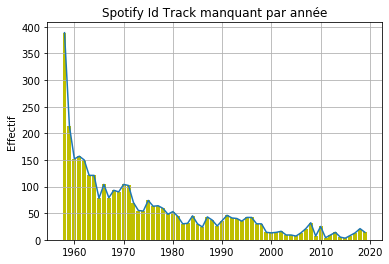

In [311]:
idMissing = xj[xj['SpotifyID'] == 0].index

xx=xj.loc[idMissing]

xx=xx['year_min'].value_counts().sort_index()

plt.plot(xx.index,xx.values)
plt.bar(xx.index,xx.values,color='y')
plt.grid()
plt.title('Spotify Id Track manquant par année')
plt.ylabel('Effectif')
plt.show()

In [148]:
keepGoodFeatures(getAudioFeatureSpotify(sp,'4LD5dhQ3kqpqe14sGPDtBC'))

{'danceability': 0.805,
 'energy': 0.941,
 'key': 0,
 'loudness': -6.584,
 'mode': 1,
 'speechiness': 0.0908,
 'acousticness': 0.0749,
 'instrumentalness': 1.45e-05,
 'liveness': 0.415,
 'valence': 0.606,
 'tempo': 106.525,
 'duration_ms': 278293}

In [36]:
getAudioFeatureSpotify(sp,'2VxeLyX666F8uXCJ0dZF8B')

{'danceability': 0.572,
 'energy': 0.385,
 'key': 7,
 'loudness': -6.362,
 'mode': 1,
 'speechiness': 0.0308,
 'acousticness': 0.371,
 'instrumentalness': 0,
 'liveness': 0.231,
 'valence': 0.323,
 'tempo': 95.799,
 'type': 'audio_features',
 'id': '2VxeLyX666F8uXCJ0dZF8B',
 'uri': 'spotify:track:2VxeLyX666F8uXCJ0dZF8B',
 'track_href': 'https://api.spotify.com/v1/tracks/2VxeLyX666F8uXCJ0dZF8B',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2VxeLyX666F8uXCJ0dZF8B',
 'duration_ms': 215733,
 'time_signature': 4}

In [143]:
url = "https://api.prd.musimap.io/oauth/access_tokens"
client_id='098e17f0-0450-4a65-9fcd-4bde878b17e1'
client_secret='SnEcbN4p73GZz6BAsC3UeAz7olVfMM1aG_KuP3PFJQch7-1s8zAe8LcpmUg4gI2mrIrEAw8xEqavV5agdbupqe82vQKtrLXKN9jH1Y2G_mBIYGDwK1TWnY80aTRUbbJcXkgttnNE22hTYoAp0ubuA5dH3cxbHSazESSCJkZsEpE'

payload = 'grant_type=client_secret&client_id='+client_id+'&client_secret='+client_secret
headers = {
  'Content-Type': 'application/x-www-form-urlencoded'
}

response = requests.request("POST", url, headers=headers, data = payload)

TOKEN_MUSIMAP=response.json()['token']


In [146]:
url = "https://api.prd.musimap.io/musimotion/live?weblink="
youtubeLink='https://p.scdn.co/mp3-preview/9a7b78842606df0c12021cba73e6883f6757387b?cid=ed490024ea5f4072810146d4d3dff356'

payload = {}
headers = {
  'Authorization': 'Bearer '+TOKEN_MUSIMAP}

response = requests.request("GET", url+youtubeLink, headers=headers, data = payload)

In [147]:
xxxx=response.json()['data']

info_seed=xxxx['seed']
info_lexico=xxxx['lexicology']

for i in info_lexico:
    print(i)
    for j in info_lexico[i]:
        print(j)

mood
{'score': 79.84987497329712, 'item': {'id': '3bf7fd61-d4a7-4cbc-8286-3fe4d17a3adf', 'name': 'Happy'}}
{'score': 71.33474707603455, 'item': {'id': 'a8e784e7-60cb-4a9a-bc67-ed2b99a8c8dc', 'name': 'Revitalizing'}}
{'score': 69.88357212127299, 'item': {'id': 'f05f72ad-e056-cea2-3bd2-e109efa0c02b', 'name': 'Happiness'}}
{'score': 68.83124262094498, 'item': {'id': '2cc908b7-d8dd-42b7-9f26-f102130b05c5', 'name': 'Lively'}}
{'score': 59.87345007150593, 'item': {'id': '1e66c428-f242-7510-c474-303c768870f4', 'name': 'Dynamism'}}
{'score': 58.698296546936035, 'item': {'id': 'f1aea1a6-ca6a-4b20-b0f6-5a8ea50f6cb6', 'name': 'Friendly'}}
{'score': 56.74162209033966, 'item': {'id': '27241d72-b61c-4f22-b390-01ac87bc1489', 'name': 'Energetic'}}
{'score': 55.24854063987732, 'item': {'id': 'bd3ac812-726f-473c-a29b-0c2234435d19', 'name': 'Glamourous'}}
{'score': 52.86633012044548, 'item': {'id': 'a03a702b-0ec4-300a-d18c-1542c9023315', 'name': 'Good vibrations'}}
{'score': 43.3598330616951, 'item': {'i

## Evolution d'une feature au fil des années

In [13]:
def evolutionOneFeatures(feature,data):
    years=[]
    means=[]
    for i in range(1958,2020):

        dfyear=data[data['year']==i][feature]
        years.append(i)
        means.append(dfyear.mean())

    plt.plot(years,means)
    plt.title('Evolution de la '+feature)
    plt.ylabel(feature)
    plt.show()

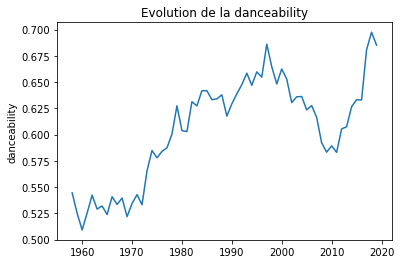

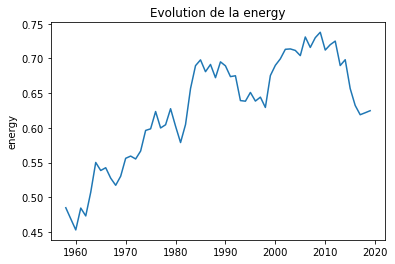

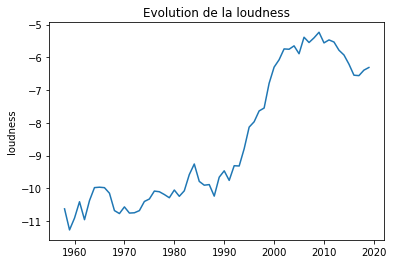

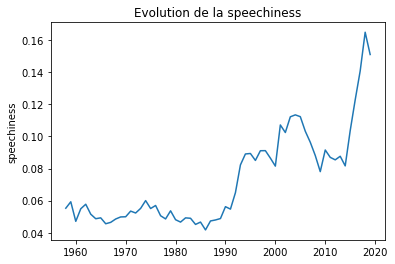

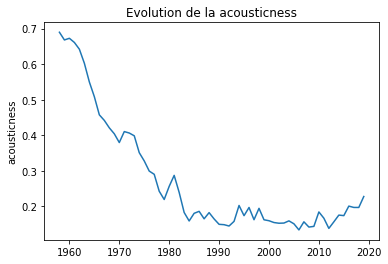

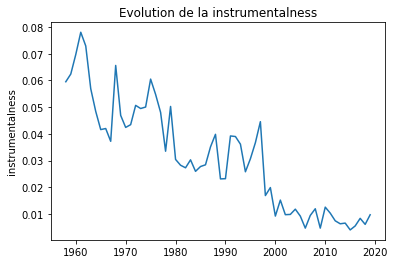

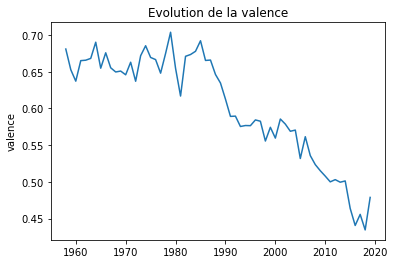

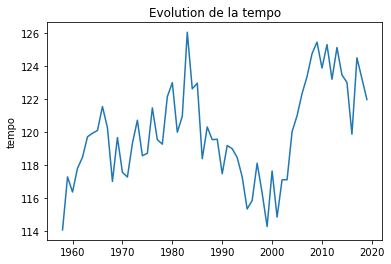

In [14]:
columns=['danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness','valence', 'tempo']
dataa=songs_features_df.dropna()
for feature in columns :
    evolutionOneFeatures(feature,dataa)

## Check which rows is missing in which dataframes

In [15]:
j=0
xx= set(songs_df['SongID'].unique())
for i in spotifyFeatures['SongID']:
    #print(i)
    if i in xx:
        pass
    else:
        j+=1
        print(i)
        print(j)

In [16]:
j=0
xx= set(songs_features_df['SongID'].unique())
for i in spotifyFeatures['SongID']:
    #print(i)
    if i in xx:
        pass
    else:
        j+=1
        print(i)
        print(j)

### 3 musiqueID etait different du dataset billboard

    '1-2-3Gloria Estefan & Miami Sound Machine'
    'Vanilla ÓlayJackie DeShannon'
    'Mercy4.0'

In [18]:
j=0
xx=set(spotifyFeatures['SongID'].unique())
for i in songs_df['SongID'].unique():
    #print(i)
    if i in xx:
        pass
    else:
        j+=1
        print(i)
        print(j)

Poor Little FoolRicky Nelson
1
One Sweet DayMariah Carey & Boyz II Men
2
Candle In The Wind 1997/Something About The Way You Look TonightElton John
3
Do I Make You ProudTaylor Hicks
4
3Britney Spears
5
Born This WayLady Gaga
6
Part Of MeKaty Perry
7
Shake It OffTaylor Swift
8
PillowtalkZayn
9
Can't Stop The Feeling!Justin Timberlake
10
Shape Of YouEd Sheeran
11
Thank U, NextAriana Grande
12
PatriciaPerez Prado And His Orchestra
13
Always Be My BabyMariah Carey
14
Tha CrossroadsBone Thugs-N-Harmony
15
4 Seasons Of LonelinessBoyz II Men
16
CrushDavid Archuleta
17
Party In The U.S.A.Miley Cyrus
18
California GurlsKaty Perry Featuring Snoop Dogg
19
BoyfriendJustin Bieber
20
Best Song EverOne Direction
21
SorryJustin Bieber
22
Cold WaterMajor Lazer Featuring Justin Bieber & MO
23
RockstarPost Malone Featuring 21 Savage
24
PsychoPost Malone Featuring Ty Dolla Sign
25
Splish SplashBobby Darin
26
One WeekBarenaked Ladies
27
CircusBritney Spears
28
She WillLil Wayne Featuring Drake
29
PayphoneM

In [19]:
j=0
xx=set(songs_features_df['SongID'].unique())
for i in songs_df['SongID'].unique():
    #print(i)
    if i in xx:
        pass
    else:
        j+=1
        print(i)
        print(j)

In [20]:
j=0
xx=set(spotifyFeatures['SongID'].unique())
for i in songs_features_df['SongID'].unique():
    #print(i)
    if i in xx:
        pass
    else:
        j+=1
        print(i)
        print(j)

Poor Little FoolRicky Nelson
1
One Sweet DayMariah Carey & Boyz II Men
2
Candle In The Wind 1997/Something About The Way You Look TonightElton John
3
Do I Make You ProudTaylor Hicks
4
3Britney Spears
5
Born This WayLady Gaga
6
Part Of MeKaty Perry
7
Shake It OffTaylor Swift
8
PillowtalkZayn
9
Can't Stop The Feeling!Justin Timberlake
10
Shape Of YouEd Sheeran
11
Thank U, NextAriana Grande
12
PatriciaPerez Prado And His Orchestra
13
Always Be My BabyMariah Carey
14
Tha CrossroadsBone Thugs-N-Harmony
15
4 Seasons Of LonelinessBoyz II Men
16
CrushDavid Archuleta
17
Party In The U.S.A.Miley Cyrus
18
California GurlsKaty Perry Featuring Snoop Dogg
19
BoyfriendJustin Bieber
20
Best Song EverOne Direction
21
SorryJustin Bieber
22
Cold WaterMajor Lazer Featuring Justin Bieber & MO
23
RockstarPost Malone Featuring 21 Savage
24
PsychoPost Malone Featuring Ty Dolla Sign
25
Splish SplashBobby Darin
26
One WeekBarenaked Ladies
27
CircusBritney Spears
28
She WillLil Wayne Featuring Drake
29
PayphoneM

In [21]:
j=0
xx=set(songs_df['SongID'].unique())
for i in songs_features_df['SongID'].unique():
    #print(i)
    if i in xx:
        pass
    else:
        j+=1
        print(i)
        print(j)

## PETIT RECAP

In [366]:
--> Centre reduire features

SyntaxError: invalid syntax (<ipython-input-366-7f905fef8cc5>, line 1)

In [22]:
songs_features_df

,SongID,year,comboWeek,comboInstance,maxPose,top1,top5,top10,spotify_genre,spotify_track_id,spotify_track_explicit,spotify_track_duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,Poor Little FoolRicky Nelson,1958,11,1,1,2,4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,One Sweet DayMariah Carey & Boyz II Men,1995,27,1,1,16,17,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Candle In The Wind 1997/Something About The Wa...,1997,42,1,1,14,16,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Do I Make You ProudTaylor Hicks,2006,8,1,1,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3Britney Spears,2009,20,1,1,1,2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28470,What'd You Come Here For?Trina & Tamara,1999,12,1,56,0,0,0,"['deep pop r&b', 'hip pop', 'miami hip hop', '...",1Mg13VMaQj4fhPtQT41vUZ,False,246000.0,0.817,0.625,-3.643,0.0719,0.0508,0.001230,0.759,102.907
28471,What's A Guy Gotta DoJoe Nichols,2005,15,2,64,0,0,0,"['arkansas country', 'contemporary country', '...",3AiNYdRmhXcv7KCFHZOddA,False,141946.0,0.637,0.963,-3.808,0.0770,0.6620,0.000031,0.920,170.224
28472,What's A Matter Baby (Is It Hurting You)Timi Yuro,1962,11,1,12,0,0,0,"['adult standards', 'brill building pop']",5w0dh39SYz1ei2tCs7X7Fo,False,165560.0,0.685,0.760,-9.354,0.0430,0.4300,0.000000,0.895,113.569
28473,Everybody Dies In Their NightmaresXXXTENTACION,2018,7,2,42,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print(len(songs_df),len(spotifyFeatures),len(songs_features_df))

28475 28377 28475


## Analyse GENRE feature

In [24]:
len(songs_features_df['spotify_genre'].unique())

3276

In [25]:
analysGenre = songs_features_df['spotify_genre'].replace(to_replace='None', value=np.nan).dropna()

In [26]:
analysGenre.value_counts()

[]                                                                                                                                                                                                                                        2541
['contemporary country', 'country', 'country road']                                                                                                                                                                                        313
['contemporary country', 'country', 'country road', 'modern country rock']                                                                                                                                                                 274
['dance pop', 'pop', 'post-teen pop']                                                                                                                                                                                                      248
['glee club', 'hollywood', 'post-teen pop'] 

In [27]:
import ast
teststr = "['dance pop', 'pop', 'post-teen pop']"
testarray = ast.literal_eval(teststr)
print(testarray,testarray[0])

['dance pop', 'pop', 'post-teen pop'] dance pop


In [28]:
import ast
genres_list={}

for i in analysGenre.dropna().unique():
    testarray = ast.literal_eval(i)
    for j in testarray:
        if not j in genres_list:
            genres_list[j]=1
        else :
            genres_list[j]+=1

In [29]:
a = sorted(genres_list.items(), key=lambda x: x[1], reverse=True)    
for i in a :
    print(i)

('rock', 324)
('dance pop', 293)
('mellow gold', 279)
('rap', 271)
('pop rap', 270)
('soft rock', 266)
('pop', 257)
('hip hop', 249)
('classic rock', 221)
('album rock', 217)
('folk rock', 211)
('pop rock', 207)
('urban contemporary', 194)
('adult standards', 194)
('new wave pop', 189)
('quiet storm', 183)
('soul', 180)
('brill building pop', 178)
('funk', 173)
('southern hip hop', 171)
('r&b', 169)
('country rock', 169)
('trap', 162)
('motown', 159)
('gangster rap', 153)
('bubblegum pop', 137)
('dance rock', 135)
('disco', 134)
('hip pop', 133)
('rock-and-roll', 132)
('classic soul', 131)
('post-teen pop', 130)
('hard rock', 126)
('folk', 125)
('post-grunge', 123)
('art rock', 122)
('blues rock', 111)
('new wave', 109)
('roots rock', 107)
('new jack swing', 104)
('new romantic', 104)
('psychedelic rock', 101)
('classic uk pop', 101)
('alternative rock', 100)
('neo mellow', 99)
('country', 98)
('hardcore hip hop', 95)
('southern soul', 94)
('post-disco', 93)
('modern rock', 90)
('europ

('hauntology', 1)
('musica per bambini', 1)
('modern downshift', 1)
('bedroom soul', 1)
('rebel blues', 1)
('alabama indie', 1)
('charlottesville indie', 1)
('western swing', 1)
('classic eurovision', 1)
('quebec indie', 1)
('rhythm and boogie', 1)
('funeral doom', 1)
('gothic doom', 1)
('space rock', 1)
('garage psych', 1)
('noise rock', 1)
('ohio indie', 1)
('nl folk', 1)
('nightcore', 1)
('ambient psychill', 1)
('psychill', 1)
('progressive psytrance', 1)
('euro hi-nrg', 1)
('ann arbor indie', 1)
('dutch r&b', 1)
('basshall', 1)
('dutch urban', 1)
('uk metalcore', 1)
('welsh metal', 1)
('deathcore', 1)
('brass band', 1)
('street band', 1)
('derby indie', 1)
('polynesian pop', 1)
('indie cafe pop', 1)
('massage', 1)
('classic russian rock', 1)
('anarcho-punk', 1)
('mod revival', 1)
('vapor pop', 1)
('brazilian psychedelic', 1)
('swedish metalcore', 1)
('deep funk house', 1)
('pinoy hip hop', 1)
('icelandic indie', 1)
('icelandic rock', 1)
('australian house', 1)
('bass house', 1)
('b

In [30]:
len(genres_list)

1118

In [31]:
len(songs_features_df['spotify_genre'].dropna().unique())

3275